In [6]:
from seagul.rl.algos import sac, ppo
from seagul.rl.algos.sac_ray import ray_sac
from seagul.rl.algos.sac_sym import sac_sym
from seagul.nn import MLP
from seagul.rl.models import SACModel, PPOModel 
import ray


input_size = 17
output_size = 6
layer_size = 128
num_layers = 2

#ray.init()

device = "cpu"
policy = MLP(input_size, output_size*2, num_layers, layer_size, device=device)
value_fn = MLP(input_size, 1, num_layers, layer_size, device=device)
q1_fn = MLP(input_size + output_size, 1, num_layers, layer_size,device=device)
q2_fn = MLP(input_size + output_size, 1, num_layers, layer_size,device=device)
model = SACModel(policy, value_fn, q1_fn, q2_fn, 1)


ppo_policy = MLP(input_size, output_size, num_layers, layer_size)
ppo_model = PPOModel(ppo_policy, value_fn)

#env_name = "Pendulum-v0"
env_name = "Walker2d-v2"
#model, rews, var_dict = ray_sac(env_name, 20000, model, env_steps=0, iters_per_update=100, min_steps_per_update=100, reward_stop=-200, exploration_steps=100)
#model, rews, var_dict = ppo(env_name, 3e5, ppo_model)

#for seed in [0]:
#    %time model, rews, var_dict = ray_sac(env_name, 160000, model, num_envs = 1, seed=seed, env_steps=0, iters_per_update=100, min_steps_per_update=100, reward_stop=-200, exploration_steps=100)


#for seed in [0]:
#    %time model, rews, var_dict = sac(env_name, 200000, model, seed=seed, env_steps=0, iters_per_update=100, min_steps_per_update=100, reward_stop=-200, exploration_steps=100)

seed = 0
model, rews, var_dict = sac(env_name, 1e6, model, seed=seed, env_steps=1600, iters_per_update=3000, min_steps_per_update=1000, reward_stop=3000, exploration_steps=10000, replay_batch_size=100, use_gpu=False)

globals().update(var_dict)

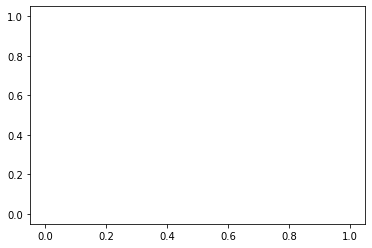

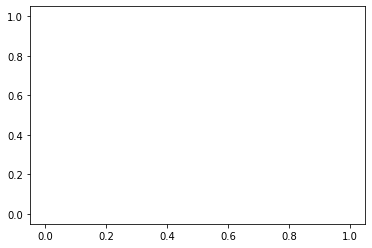

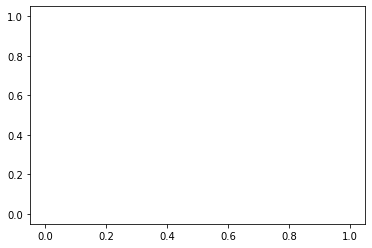

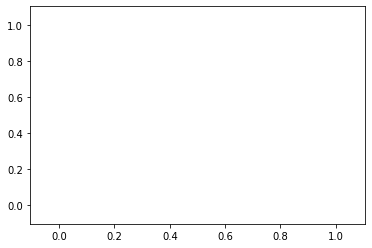

In [6]:
import matplotlib.pyplot as plt

plt.plot(raw_rew_hist)
plt.figure()
plt.plot(pol_loss_hist)
plt.figure()
plt.plot(val_loss_hist)
plt.figure()
plt.plot(q1_loss_hist)
plt.plot(q2_loss_hist)


In [5]:
replay_obs1, replay_obs2, replay_acts, replay_rews, replay_done = replay_buf.sample_batch(replay_batch_size)


In [ ]:
replay_buf.sample_batch()

In [ ]:
import gym
import torch
env = gym.make(env_name)
done = False
obs = env.reset()

obs_list = []
act_list = []
rew_list = []
avg_list = []
val_list = []

 
dtype = torch.float32
act_size = env.action_space.shape[0]
obs = env.reset()
done = False

while not done:
    model_obs = torch.as_tensor(obs, dtype=dtype).detach() #TODO.... (or not, this still works with ppo right??)
    obs_list.append(obs)
    
    noise = torch.randn(act_size)
    act, logp = model.select_action(model_obs.reshape(1, -1), noise)
    act = act.detach()

    obs, rew, done, _ = env.step(act.numpy().reshape(-1))
    env.render()

    act_list.append(act)
    rew_list.append(rew)

print(sum(rew_list))
plt.plot(obs_list)
plt.figure()
plt.plot(act_list)
plt.figure()
plt.plot(rew_list)
plt.figure()
plt.plot(val_list)
plt.figure()
plt.plot(avg_list)
    